In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
from itertools import islice

In [23]:
# Parameters

dataset = 'infectious'
beta = 1
Delta_T = 0.1 # Fraction of dataset to select (this is then divided by phi)
k = 10
phi = 0.1
lines = 0
runs = 3

if dataset == "infectious":
    lines = 17298
elif dataset == "ht09_contact":
    lines = 20818
elif dataset == "SFHH":
    lines = 70261
elif dataset == "tij":
    lines = 78249

total_edges = int(lines * Delta_T)
random_start_point = np.random.uniform(0, float(1 - Delta_T))
start = int(lines * random_start_point)

train_lines = int(total_edges * float(1 - phi))
mid = start + train_lines
end = start + total_edges

print(f'Starting at {start} till {mid} to predict till {end}')

path_to_file = f'../data/{dataset}.txt'

all_data = np.loadtxt(path_to_file, delimiter='\t', dtype=int)[start: end]
train_data = all_data[:train_lines]
predict_data = all_data[mid:]

# Check all edges are unique

# a = np.array([src, dst, ts])
# a = a.T
# # np.any(np.all(np.unique(a, axis=1) == a, axis=1))
# u, c = np.unique(a, return_counts=True, axis=0)
# u[c > 1]

Starting at 2048 till 3604 to predict till 3777


In [15]:
# Construct Graph

src, dst, ts = [], [], []
graph = nx.MultiGraph()

for line in train_data:
    src.append(line[0])
    dst.append(line[1])
    ts.append(line[2])

    if graph.nodes.get(line[0]) is None:
        graph.add_node(line[0], is_infected=False, infected_at=math.inf)
    if graph.nodes.get(line[1]) is None:
        graph.add_node(line[1], is_infected=False, infected_at=math.inf)

    graph.add_edge(line[0], line[1], key=line[2], timestamp=line[2])

src, dst, ts = np.array(src), np.array(dst), np.array(ts) # ts is given sorted
print(graph)

MultiGraph with 80 nodes and 1556 edges


In [24]:
# Calculate node influences

rng = np.random.RandomState(69)

node_influences = []

# for each node in the graph
for node in graph.nodes:
    if not np.any(src == node):
        node_influences.append(0)
        continue
    t_0 = np.min(ts[src == node])

    graph.nodes[node]['is_infected'] = True
    graph.nodes[node]['infected_at'] = t_0

    # for every timestep in (t_0, t_0 + Delta_T)
    for t in range(t_0 + 1, mid):
        # if off bounds, continue
        if t not in ts:
            continue
        # for every node in the graph
        for n, nbrs in graph.adjacency():
            # if the node is infected
            if graph.nodes[n]['is_infected']:
                # get its neighbors at that timestamp
                for nbr, eattr in nbrs.items():
                    if t in eattr.keys() and graph.nodes[n]['infected_at'] < t:
                        # infect them with probability b
                        if rng.uniform() <= beta:
                            # print(f"Marking {nbr} as infected at {t} since {n} was infected at {G.nodes[n]['infected_at']}")
                            graph.nodes[nbr]['is_infected'] = True
                            graph.nodes[nbr]['infected_at'] = t

    # node influence
    node_influences.append(len([n for n in graph.nodes if graph.nodes[n]['is_infected']]) / len(graph.nodes))

    # reset graph
    for n in graph.nodes:
        graph.nodes[n]['is_infected'] = False

node_influences = np.array(node_influences)

node_influences

array([0.8125, 0.7625, 0.9125, 0.8625, 0.8   , 0.8   , 0.875 , 0.9   ,
       0.9125, 0.05  , 0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125,
       0.825 , 0.1875, 0.825 , 0.825 , 0.9   , 0.825 , 0.9   , 0.8625,
       0.    , 0.9125, 0.8375, 0.8375, 0.8   , 0.3625, 0.8125, 0.8125,
       0.8875, 0.6125, 0.8125, 0.0125, 0.8125, 0.8125, 0.8125, 0.825 ,
       0.875 , 0.825 , 0.8375, 0.8125, 0.875 , 0.    , 0.0125, 0.8125,
       0.825 , 0.0125, 0.0375, 0.8125, 0.8125, 0.8125, 0.0375, 0.0125,
       0.0375, 0.    , 0.0875, 0.4625, 0.8125, 0.75  , 0.8125, 0.8125,
       0.75  , 0.8125, 0.    , 0.3125, 0.525 , 0.    , 0.5625, 0.    ,
       0.3625, 0.    , 0.    , 0.175 , 0.3625, 0.    , 0.025 , 0.    ])

In [17]:
# Construct subgraphs and calculate subgraph-related metrics

####### labels #######
labels = [
    'Number of union of contacts in [t_0, t_0 + phi*Delta_T]',
    'Closeness Centrality',
    # 'Wiener Indices',
    'Betweenness Centrality',
    # 'Subgraph Centrality',
    'VoteRank',
    'Degree',
    'Degree Assortativity Coefficient',
    'Harmonic Centrality',
    'Local Reaching Centrality',
    # 'Eigenvector Centrality'
]

metrics = [[] for _ in labels]
for node in graph.nodes:
    if not np.any(src == node) or not np.any(dst == node):
        for i in range(len(metrics)):
            metrics[i].append(0)
        continue
    # get the index of the first time that node appears
    start_src_idx = np.min(np.arange(len(src))[src == node])
    start_dst_idx = np.min(np.arange(len(src))[dst == node])
    start_idx = min(start_src_idx, start_dst_idx)
    # t_0 = ts[start_idx]

    subgraph = nx.MultiGraph()  # subgraph in (t_0, t_0 + Delta_T)
    i = start_idx
    j = ts[i]
    while i < len(src) and ts[i] < end:
        subgraph.add_edge(src[i], dst[i], key=ts[i])
        i += 1

    ####### metrics #######
    metrics[0].append(len(nx.single_source_shortest_path(subgraph, node, cutoff=k)))
    metrics[1].append(nx.closeness_centrality(subgraph, node))
    # metrics[2].append(nx.wiener_index(subgraph))
    metrics[2].append(nx.betweenness_centrality(subgraph)[node])
    # metrics[3].append(nx.subgraph_centrality(subgraph)[node])
    metrics[3].append(np.argmax(nx.voterank(subgraph)))
    metrics[4].append(subgraph.degree[node])
    metrics[5].append(nx.degree_assortativity_coefficient(subgraph))
    metrics[6].append(nx.harmonic_centrality(subgraph)[node])
    metrics[7].append(nx.local_reaching_centrality(subgraph, node))
    # metrics[10].append(nx.eigenvector_centrality(subgraph)[node])

for i, m in enumerate(metrics):
    m = np.array(m)
    m = np.abs(m)
    ma = np.max(m[m != np.inf])
    m = m / ma # scale it to 0-1
    m[m == np.inf] = 1
    metrics[i] = m

In [18]:
# Calculate MSEs

y = node_influences
mse = []
for m in metrics:
    mse.append((np.sum(m - y)**2) / len(y))
list(zip(labels, mse))

[('Number of union of contacts in [t_0, t_0 + phi*Delta_T]',
  2.1699745119892655),
 ('Closeness Centrality', 0.14931006111171358),
 ('Betweenness Centrality', 11.87214222049305),
 ('VoteRank', 1.941423828125),
 ('Degree', 4.70305665834042),
 ('Degree Assortativity Coefficient', 2.975801745298235),
 ('Harmonic Centrality', 0.016259365683793135),
 ('Local Reaching Centrality', 0.11078013678320028)]

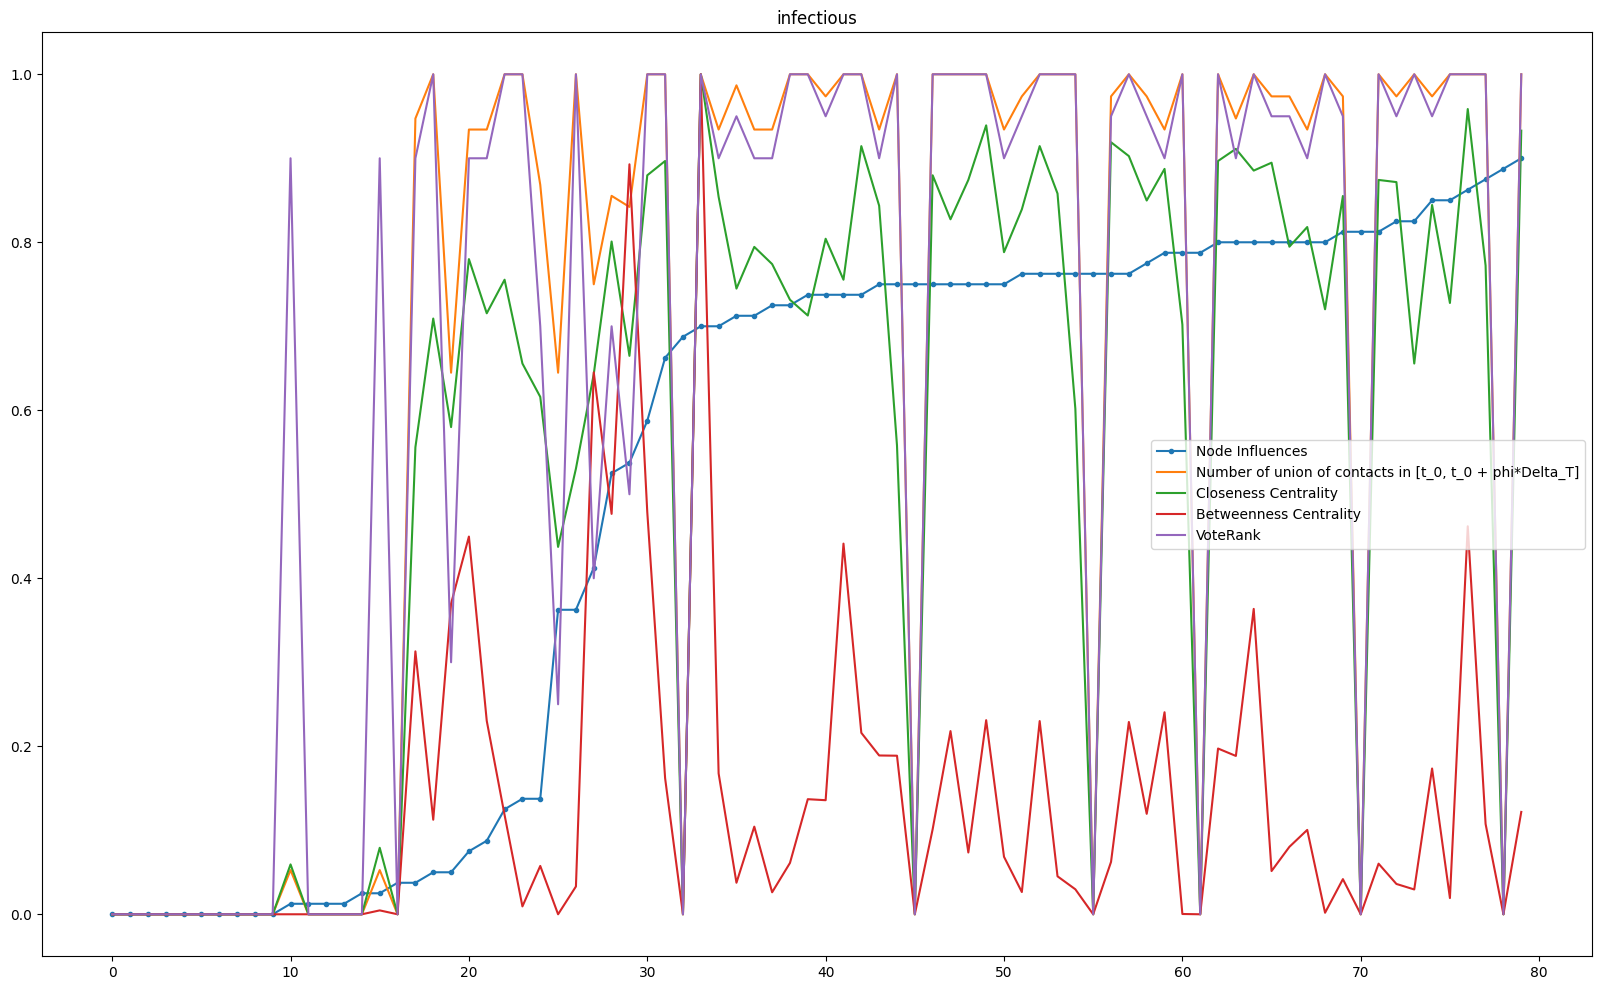

In [21]:
# Plot

# sort to compare cumulatively
sort = True

x = np.arange(len(node_influences))

plot_metrics = metrics.copy()

sort_idxs = np.argsort(node_influences)
y = node_influences[sort_idxs] if sort else node_influences
for i, m in enumerate(metrics):
    plot_metrics[i] = m[sort_idxs] if sort else m

fig, ax1 = plt.subplots(figsize=(20, 12))
ax1.plot(x, y, '.-', label='Node Influences')
for i, m in enumerate(plot_metrics[:4]):
    ax1.plot(x, m, label=labels[i])
plt.title(dataset)
plt.legend()
plt.savefig(f'{dataset}{"-cumulative" if sort else ""}.png')

Conclusions

Useful metrics that seem to model closely to the node influences, apart from Num. of union of contacts:

|dataset      | n_nodes | n_edges | beta |Delta_T|duration|k    |phi  |best metrics|
| ----------- |-------- | ------- | ---- | ----- | ------ | --- | --- | ---------- |
| ht09        |  113    |  20818  | 0.8  | 1000  | 27s    | 5   | 0.5 | Closeness Centrality, Degree Assortativity Coefficient     |
| infectious  |     410 |  17298  | 0.6  | 500   | 67s    | 5   | 0.5 | Eigenvalue Centrality does not converge, so removed. Betweeness/Subgraph centrality. |
| SFHH        |     403 | 70261   | 0.6  | 500   |  180s  | 5   | 0.5 | Eigen. not converging, removed. Num of union of contacts, Degree, Harmonic/Local-Reaching Centralities. |    
| tij_lnVS15  |   217   | 78249   | 0.6  | 500   |  21s   | 5   | 0.5 | Eigen. again not conv., removed. Betweeness/Subgraph centralities |


In [20]:
fit = np.polyfit(y, np.array([metrics[0], metrics[1]]).T, 1) #The use of 1 signifies a linear fit.
# line = np.poly1d(fit)
# len(np.array([metrics[0], metrics[1]]).T)
fit
np.poly(fit)

array([ 1.        , -0.97899083, -0.03925148])